# Classification of raster timeseries with xr_fresh, geowombat and sklearn

In [1]:
import geowombat as gw
import os
from datetime import datetime
import matplotlib.pyplot as plt
import pandas as pd
from glob import glob
import tempfile
from pathlib import Path
from xr_fresh.feature_calculator_series import (
    minimum,
    abs_energy,
    mean_abs_change,
    ratio_beyond_r_sigma,
    symmetry_looking,
    sum,
    quantile,
    function_mapping,
)

# make temp directory for outputs
temp_dir = Path(tempfile.mkdtemp())
# Set up error logging
import logging

# set up error logging
logging.basicConfig(
    filename=os.path.join(temp_dir, "error_log.log"),
    level=logging.ERROR,
    format="%(asctime)s:%(levelname)s:%(message)s",
)
# Read in example data
os.chdir("../../xr_fresh/data/")

band_name = "ppt"  # used to rename outputs
file_glob = f"pdsi*tif"
strp_glob = f"pdsi_%Y%m_4500m.tif"

dates = sorted(
    datetime.strptime(string, strp_glob) for string in sorted(glob(file_glob))
)
files = sorted(glob(file_glob))

# print dates and files in a table
pd.DataFrame({"date": dates, "file": files})

/home/mmann1123/miniconda3/envs/xr_fresh_update/lib/python3.9/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


,date,file
0,2018-01-01,pdsi_201801_4500m.tif
1,2018-02-01,pdsi_201802_4500m.tif
2,2018-03-01,pdsi_201803_4500m.tif
3,2018-04-01,pdsi_201804_4500m.tif
4,2018-05-01,pdsi_201805_4500m.tif
5,2018-06-01,pdsi_201806_4500m.tif
6,2018-07-01,pdsi_201807_4500m.tif
7,2018-08-01,pdsi_201808_4500m.tif
8,2018-09-01,pdsi_201809_4500m.tif
9,2018-10-01,pdsi_201810_4500m.tif


In [2]:
from xr_fresh.extractors_series import extract_features_series

# Define the feature dictionary
feature_dict = {
    "minimum": [{}],
    "abs_energy": [{}],
    "doy_of_maximum": [{"dates": dates}],
    "mean_abs_change": [{}],
    "ratio_beyond_r_sigma": [{"r": 1}, {"r": 2}],
    "symmetry_looking": [{}],
    "sum": [{}],
    "quantile": [{"q": 0.05}, {"q": 0.95}],
}

# Define the band name and output directory
band_name = "ppt"

# Extract features from the geospatial time series
extract_features_series(
    files, feature_dict, band_name, temp_dir, num_workers=12, nodata=-9999
)

100%|██████████| 4/4 [00:00<00:00, 5087.09it/s]


In [3]:
features = sorted(glob(os.path.join(temp_dir, "*.tif")))
feature_names = [os.path.basename(f).split(".")[0] for f in features]

pd.DataFrame({"feature": feature_names, "file": features})

,feature,file
0,ppt_abs_energy,/tmp/tmpupau0mxr/ppt_abs_energy.tif
1,ppt_doy_of_maximum_dates,/tmp/tmpupau0mxr/ppt_doy_of_maximum_dates.tif
2,ppt_mean_abs_change,/tmp/tmpupau0mxr/ppt_mean_abs_change.tif
3,ppt_minimum,/tmp/tmpupau0mxr/ppt_minimum.tif
4,ppt_quantile_q_0,/tmp/tmpupau0mxr/ppt_quantile_q_0.05.tif
5,ppt_quantile_q_0,/tmp/tmpupau0mxr/ppt_quantile_q_0.95.tif
6,ppt_ratio_beyond_r_sigma_r_1,/tmp/tmpupau0mxr/ppt_ratio_beyond_r_sigma_r_1.tif
7,ppt_ratio_beyond_r_sigma_r_2,/tmp/tmpupau0mxr/ppt_ratio_beyond_r_sigma_r_2.tif
8,ppt_sum,/tmp/tmpupau0mxr/ppt_sum.tif
9,ppt_symmetry_looking,/tmp/tmpupau0mxr/ppt_symmetry_looking.tif


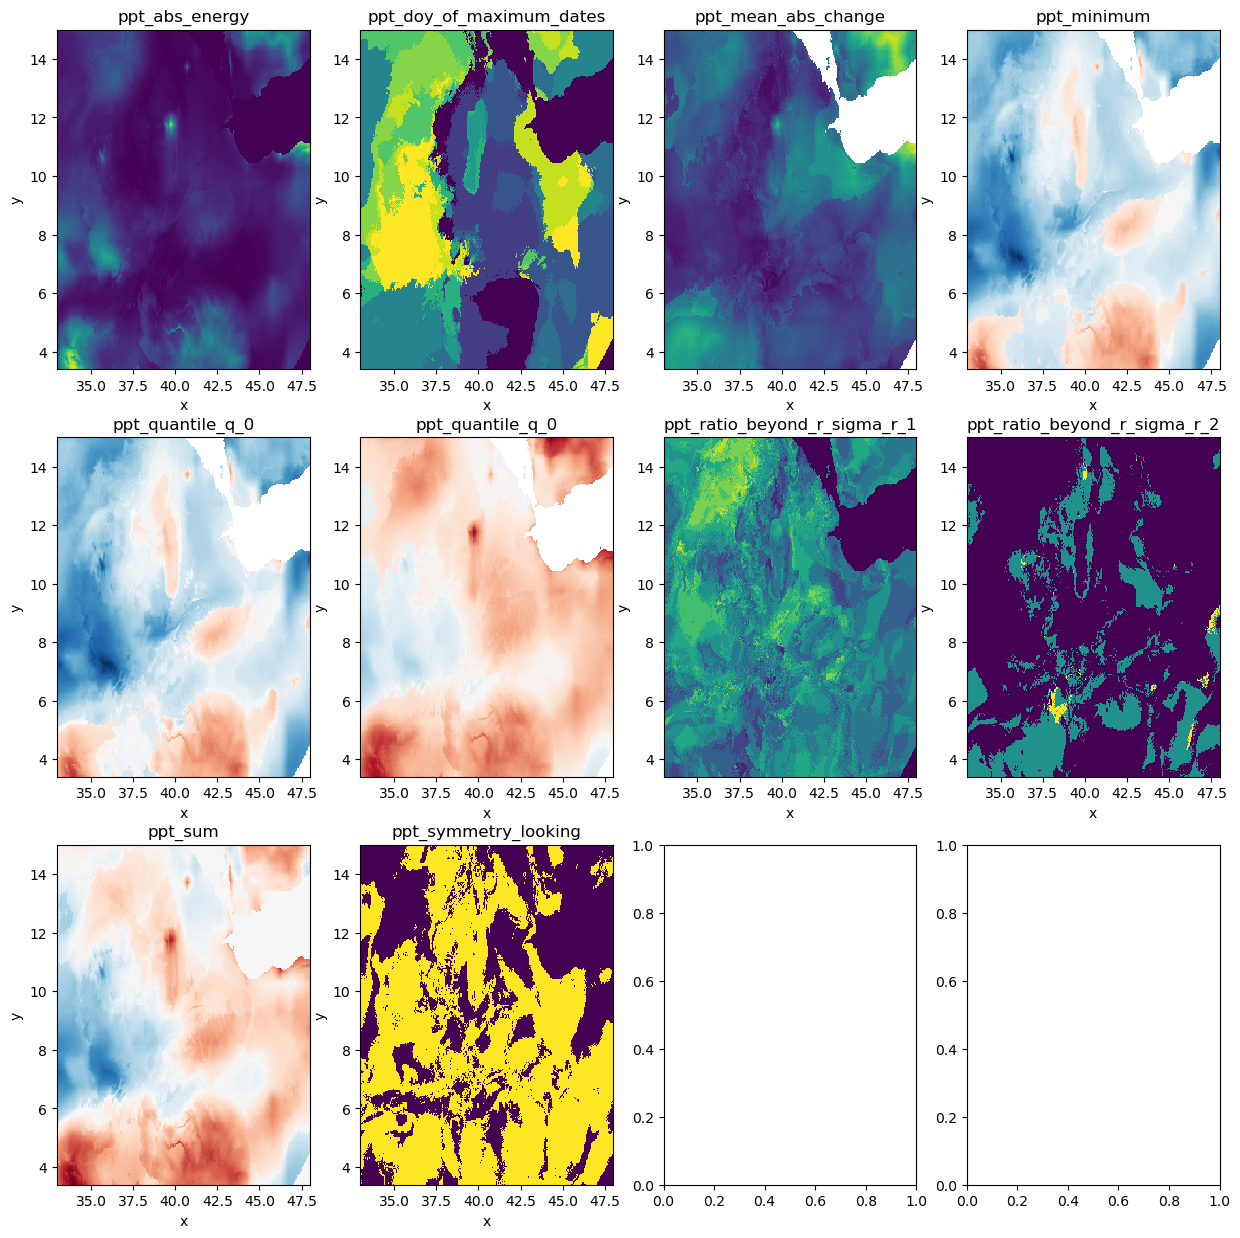

In [4]:
# plot the features in 3x3 grid
fig, axes = plt.subplots(3, 4, figsize=(15, 15))
axes = axes.flatten()

for i, feature in enumerate(features):
    with gw.open(feature) as src:
        src.plot(ax=axes[i], add_colorbar=False)
        axes[i].set_title(feature_names[i])
        # src.plot(robust=True)
        # plt.title(feature_names)
        # plt.show()

## Create a unsupervised classification of timeseries features 

In this example we will create a non-sense classification. The goal is to show how to use `xr_fresh` to create a timeseries feature dataset and then use `geowombat` to classify the dataset using `sklearn`. 

Notice the use of `SimpleImputer` to fill missing values to learn more about this see the [pygis.io tutorial](https://pygis.io/docs/f_rs_ml_predict.html#handling-missing-data)

Note: You will need to install some additional features for `geowombat` by running
`mamba install geowombat-ml -c conda-forge`

<xarray.DataArray (band: 10, y: 287, x: 371)>
dask.array<concatenate, shape=(10, 287, 371), dtype=float64, chunksize=(1, 256, 256), chunktype=numpy.ndarray>
Coordinates:
  * band     (band) int64 1 1 1 1 1 1 1 1 1 1
  * x        (x) float64 33.01 33.05 33.09 33.13 ... 47.84 47.88 47.92 47.96
  * y        (y) float64 14.98 14.94 14.9 14.86 ... 3.537 3.497 3.456 3.416
Attributes: (12/13)
    transform:           (0.040424187785378464, 0.0, 32.98613723286883, 0.0, ...
    crs:                 4326
    res:                 (0.040424187785378464, 0.040424187785378464)
    is_tiled:            0
    nodatavals:          (-9999,)
    _FillValue:          -9999
    ...                  ...
    offsets:             (0.0,)
    filename:            ['ppt_abs_energy.tif', 'ppt_doy_of_maximum_dates.tif...
    resampling:          nearest
    AREA_OR_POINT:       Area
    _data_are_separate:  1
    _data_are_stacked:   1

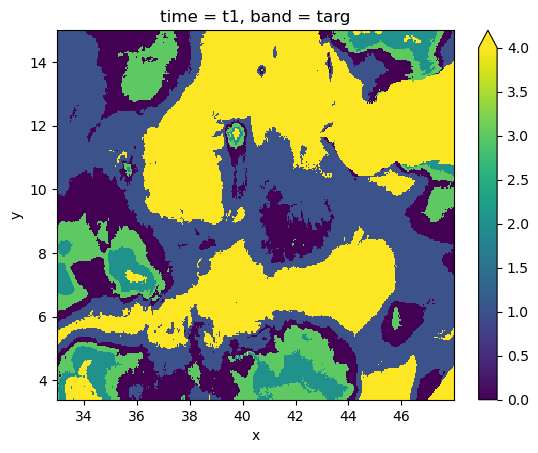

In [5]:
from sklearn.cluster import KMeans
from sklearn.pipeline import Pipeline
from geowombat.ml import fit_predict
from sklearn.impute import SimpleImputer  
import numpy as np

cl = Pipeline(
    [
        ("remove_nan", SimpleImputer(missing_values=np.nan, strategy="mean")),
        ("clf", KMeans(n_clusters=6, random_state=0)),
    ]
)

# fit the pipeline and plot
with gw.open(features, stack_dim="band", nodata=-9999) as src:
    display(src)
    y = fit_predict(src, cl)
    y.plot(robust=True)

In [6]:
# remove files from temp directory
import shutil
shutil.rmtree(temp_dir)